# Conexão com postgres e Relatorios do Sistema

## Instalando biblioteca de acesso com postgres e manipulação de dados e gráficos

In [16]:
!pip install --user psycopg2-binary
!pip install --user seaborn
!pip install --user pandas

### Importando bibliotecas

In [17]:
import seaborn as sns
import pandas as pd
import psycopg2

### Usando psycopg2 para configurar conexão

In [18]:
conn = psycopg2.connect(host="localhost",database="resolve_ae", user="postgres", password="postgres", port= 5432)

## Obtendo dados do database com Pandas

# Relatório 1

#### Objetivo: Obter o número de serviços por tipo de formação acadêmica/técnica


Código para obtenção do resultado:

In [19]:
test = pd.read_sql_query(
    """
        SELECT
            TIP.nome AS "QUALIFICACAO",
            COUNT(DISTINCT S.id) AS "SERVICOS_CADASTRADOS"
        FROM SERVICO AS S
            INNER JOIN USUARIO AS U ON U.id = S.fk_usuario
            INNER JOIN info_profissional AS IP ON IP.fk_usuario = U.id
            INNER JOIN tipo_info_profissional AS TIP ON TIP.id = IP.fk_tipo_info_prof
        WHERE 1=1
            AND TIP.id >= 1
            AND TIP.ID<=4
        GROUP BY TIP.nome
        ORDER BY "SERVICOS_CADASTRADOS"
    """,conn)

In [20]:
test

,QUALIFICACAO,SERVICOS_CADASTRADOS
0,PÓS-GRADUAÇÃO,113680
1,GRADUAÇÃO,114015
2,CURSO TÉCNICO,114188
3,DOMÍNIO TECNOLÓGICO,114250


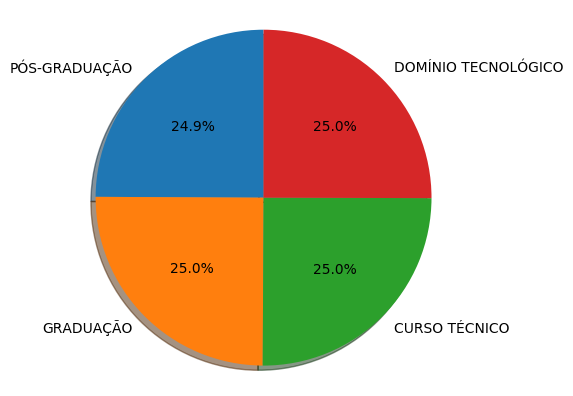

In [21]:
df = pd.DataFrame(test)
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.QUALIFICACAO
sizes = df.SERVICOS_CADASTRADOS
explode = (0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Relatorio2

#### Objetivo: Número de contratos por tipo/área do serviço

codigo para obtenção do resultado:

In [22]:
result = pd.read_sql_query(
    """
        SELECT
            TS.nome,
            COUNT(DISTINCT S.id) AS "NUMERO_CONTRATOS"
        
        FROM usuario AS U
            INNER JOIN avaliacao AS A ON A.fk_usuario = U.id
            INNER JOIN servico AS S ON S.id = A.fk_servico
            INNER JOIN servico_subtipo_servico AS SSS ON SSS.fk_servico = S.id
            INNER JOIN subtipo_servico AS SB ON SB.id = SSS.fk_subtipo_servico
            INNER JOIN tipo_servico as TS ON TS.id = SB.fk_tipo_servico
            INNER JOIN endereco AS E ON E.fk_usuario = U.id
            INNER JOIN bairro AS B ON B.id = E.fk_bairro
            INNER JOIN cidade AS C ON C.id = B.fk_cidade
            INNER JOIN estado AS UF ON UF.id = C.fk_estado
        WHERE UF.id = 2
        GROUP BY TS.nome
        ORDER BY "NUMERO_CONTRATOS"
    """,conn)

In [23]:
result

,nome,NUMERO_CONTRATOS
0,Banco de Dados,539
1,Desenvolvimento,550
2,Design,573
3,Análise de Sistemas,589
4,Infraestrutura,614


Alternativamente podemos aplicar estilos a tabela para melhor formatação usando pandas e seaborn

In [27]:
df = pd.DataFrame(result)
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)


,nome,NUMERO_CONTRATOS
0,Banco de Dados,539
1,Desenvolvimento,550
2,Design,573
3,Análise de Sistemas,589
4,Infraestrutura,614


Podemos também utilizar o matplotlib que é instalado por padrão com o seaborn

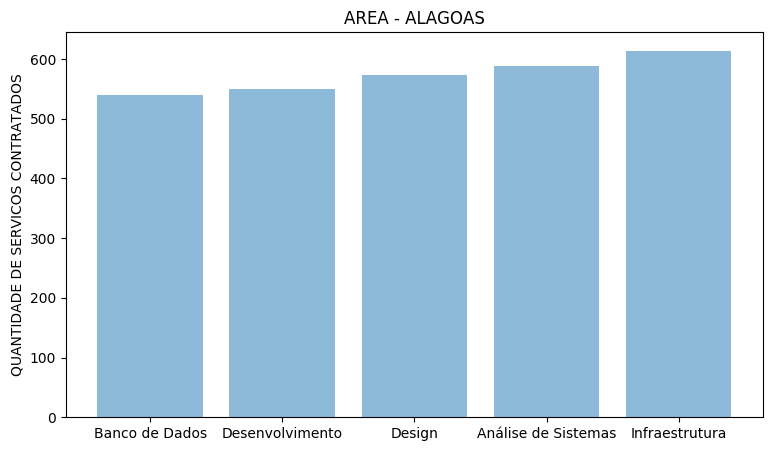

In [39]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = tuple(df.nome)
y_pos = np.arange(len(objects))
performance = list(df.NUMERO_CONTRATOS)

plt.rcParams['figure.figsize'] = [9, 5]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('QUANTIDADE DE SERVICOS CONTRATADOS')
plt.title('AREA - ALAGOAS')
 
plt.show()

## Relatório 3

#### Objetivo: Obter por estado, o número de serviços de um determinado tipo.

codigo para obtenção do resultado:

In [40]:
result = pd.read_sql_query(
    """
        SELECT
            UF.NOME,
            COUNT(DISTINCT S.id) AS "TOTAL_SERVICOS"
        FROM estado AS UF
            INNER JOIN cidade AS C ON C.fk_estado = UF.id
            INNER JOIN bairro AS B ON B.fk_cidade = C.id
            INNER JOIN endereco AS E ON E.fk_bairro = B.id
            INNER JOIN usuario AS U ON E.fk_usuario = U.id
            INNER JOIN servico AS S ON S.fk_usuario = U.id
            INNER JOIN servico_subtipo_servico AS SSS ON SSS.fk_servico = S.id
            INNER JOIN subtipo_servico AS SB ON SB.ID = SSS.fk_subtipo_servico
            INNER JOIN tipo_servico AS TS ON TS.id = SB.fk_tipo_servico
        WHERE TS.ID = 2
        GROUP BY UF.nome
        ORDER BY "TOTAL_SERVICOS" DESC,UF.nome DESC
    """,conn)

In [41]:
print("CONTRATACOES DA AREA DE BANCO DE DADOS")
result

CONTRATACOES DA AREA DE BANCO DE DADOS


,nome,TOTAL_SERVICOS
0,Rio Grande do Sul,26523
1,Santa Catarina,18248
2,Ceará,17454
3,São Paulo,10890
4,Minas Gerais,9561
5,Paraná,6913
6,Pernambuco,5977
7,Mato Grosso,4475
8,Espírito Santo,4246
9,Amazonas,4214


## Relatório 4

#### Objetivo: Obter a média de avaliações por área.

codigo para obtenção do resultado:

In [47]:
result = pd.read_sql_query(
    """
        SELECT
            TS.nome AS "AREA",
            SUM(A.nota)/COUNT(TS.*) AS "MEDIA_AREA",
            COUNT(A.id) AS "NUMERO_AVALIACOES",
            SUM(A.nota) AS "SOMA_NOTAS"

        FROM tipo_servico AS TS
            INNER JOIN subtipo_servico AS SB ON SB.fk_tipo_servico = TS.id
            INNER JOIN servico_subtipo_servico AS SSS ON SSS.fk_subtipo_servico = SB.id
            INNER JOIN servico AS S ON S.id = SSS.fk_servico
            INNER JOIN avaliacao AS A ON A.fk_servico = S.id
        GROUP BY TS.nome
        ORDER BY "MEDIA_AREA" DESC
    """,conn)

In [48]:
result

,AREA,MEDIA_AREA,NUMERO_AVALIACOES,SOMA_NOTAS
0,Banco de Dados,3,132638,398477
1,Design,3,133106,400156
2,Infraestrutura,3,133337,400038
3,Análise de Sistemas,2,133065,399156
4,Desenvolvimento,2,132922,398497


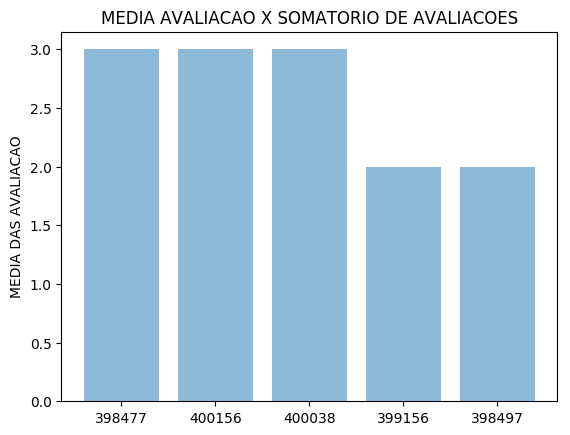

In [49]:
df = pd.DataFrame(result)
cm = sns.light_palette("blue", as_cmap=True)
df.style.background_gradient(cmap=cm)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = tuple(df.SOMA_NOTAS)
y_pos = np.arange(len(objects))
performance = list(df.MEDIA_AREA)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MEDIA DAS AVALIACAO')
plt.title('MEDIA AVALIACAO X SOMATORIO DE AVALIACOES')
 
plt.show()

## Relatório 5

#### Objetivo: Obter a média de preço de cada área.

codigo para obtenção do resultado:

In [60]:
result = pd.read_sql_query(
    """
        SELECT
            TS.nome AS "AREA",
            SUM(S.valor)/COUNT(S.*) AS "MEDIA_AREA"

        FROM tipo_servico AS TS
            INNER JOIN subtipo_servico AS SB ON SB.fk_tipo_servico = TS.id
            INNER JOIN servico_subtipo_servico AS SSS ON SSS.fk_subtipo_servico = SB.id
            INNER JOIN servico AS S ON S.id = SSS.fk_servico

        GROUP BY TS.nome
        ORDER BY "MEDIA_AREA"
    """,conn)

In [61]:
result

,AREA,MEDIA_AREA
0,Análise de Sistemas,37.467092
1,Banco de Dados,37.472406
2,Infraestrutura,37.502403
3,Design,37.523921
4,Desenvolvimento,37.525869


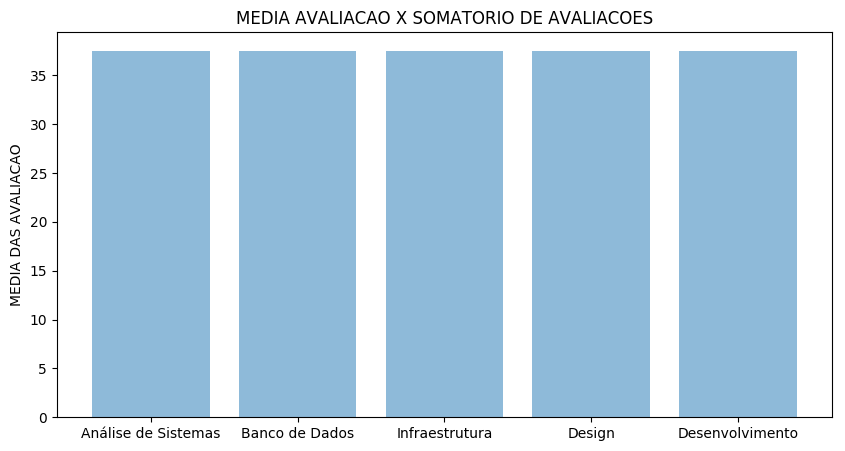

In [66]:
df = pd.DataFrame(result)
cm = sns.light_palette("blue", as_cmap=True)
df.style.background_gradient(cmap=cm)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = tuple(df.AREA)
y_pos = np.arange(len(objects))
performance = list(df.MEDIA_AREA)

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MEDIA DAS AVALIACAO')
plt.title('MEDIA AVALIACAO X SOMATORIO DE AVALIACOES')
 
plt.show()

# Referencias

https://pandas.pydata.org/pandas-docs/stable/style.html <br>
https://pythonspot.com/matplotlib-bar-chart/<br>
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html <br>